**Work in progress**

I'm interested in prescribing of Lidocaine patches since 2015. Details of lidocaine plasters prescribing can be seen on [OpenPrescribing here](https://openprescribing.net/measure/lplidocaine/national/england/). Previous DataLab work on evaluation on the impact of NHS England guidance can be viewed [here in JRSM](https://journals.sagepub.com/doi/10.1177/0141076818808429)

The following example notebooks for reference for re-using code snippets
- https://github.com/ebmdatalab/lidocaine-change-detection-notebook/blob/master/notebooks/ccg-lidocaine-change.ipynb
- https://github.com/ebmdatalab/jupyter-notebooks/blob/master/Dementia%20Prescribing/Dementia%20Prescribing.ipynb
- https://github.com/ebmdatalab/jupyter-notebooks/blob/master/new_measures/Gabapentinoids/New%20Measure%20-%20Gabapentin%20and%20Pregabalin%20DDD.ipynb
- https://github.com/ebmdatalab/cd-legislation-notebook/blob/master/notebooks/legislative.change.ipynb
    

## Data Extraction

- Lidocaine here
- See below for list size (add navigation later)

In [9]:
#import libraries required for analysis
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq, charts, maps
import os

In [10]:
## ensuring the format is consistent for pounds and pence
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [11]:
## here we will extract all prescribing of Lidocaine patches by ccg (prev named pct)
sql= '''
SELECT
DATE(month) AS month,
  pct,
  SUM(quantity) AS quantity_of_plasters,
  SUM(items) AS rx_items,
  SUM(actual_cost) AS actual_cost,
  SUM(net_cost) AS net_cost
FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS rx
  INNER JOIN hscic.ccgs AS ccg ON rx.pct = ccg.code 
WHERE
  bnf_code LIKE "1502010J0%EL" # brand and Lidocaine patches
  AND month >= "2015-01-01"
  AND ccg.org_type = 'CCG' #restrict to only ccg orgs i.e. exclude OOH etc
GROUP BY
   month,
   pct
 '''

df_lidocaine = bq.cached_read(sql, csv_path=os.path.join('..', 'data','lidocaine.csv'), use_cache=True)
df_lidocaine['month'] = df_lidocaine['month'].astype('datetime64[ns]')
df_lidocaine.head(10)

,month,pct,quantity_of_plasters,rx_items,actual_cost,net_cost
0,2016-09-01,W2U3Z,40850,1266,91378.14,98584.52
1,2015-02-01,D2P2L,6065,206,13546.21,14636.78
2,2015-08-01,B2M3M,2920,110,6518.66,7046.88
3,2015-06-01,70F,9260,287,21388.25,23107.68
4,2015-09-01,01W,1225,37,3540.33,3825.12
5,2015-09-01,02P,1825,60,4077.00,4404.32
6,2016-01-01,10Q,4885,161,10892.43,11789.17
7,2015-07-01,13T,5255,170,11733.14,12682.07
8,2015-01-01,26A,2800,85,6238.63,6757.31
9,2015-05-01,72Q,32610,1055,81846.38,88450.06


In [12]:
## add list size

In [13]:
# get data for patient list size (all patients)
sql2 = """
SELECT 
DATE(month) AS month, 
pct_id AS pct, 
sum(total_list_size) as list_size
FROM ebmdatalab.hscic.practice_statistics
group by 
month, pct
order by
month, pct
"""
listsize_df = bq.cached_read(sql2, csv_path=os.path.join('..', 'data''list_size.csv'))
listsize_df['month'] = listsize_df['month'].astype('datetime64[ns]')
listsize_df.head()

,month,pct,list_size
0,2015-01-01,NaN,0
1,2015-01-01,00C,106673
2,2015-01-01,00D,288824
3,2015-01-01,00F,207011
4,2015-01-01,00G,163290


In [ ]:
#Merge data into single dataframe

##df_qty=df_lidocaine.groupby(["month", "pct"])['quantity_of_plasters'].sum().to_frame(name = 'quantity_of_plasters').reset_index()
##df_qty.head()
#plot data on graph
#gaba_df.groupby(["month"])['pregab_mg'].sum().plot(kind='line', title="Total pregabalin mg eq prescribing of gabape

In [ ]:
#merge dataframes
#per_1000_df = pd.merge(df_qty, listsize_df, on=['month', 'pct'])
#per_1000_df['plasters_per_1000'] = 1000* (per_1000_df['quantity_of_plasters']/per_1000_df['list_size'])
#per_1000_df.head()

In [6]:
lidocaine_and_listsize = pd.merge(df_lidocaine, listsize_df, on=['month', 'pct'])
lidocaine_and_listsize['plasters_per_1000'] = 1000* (lidocaine_and_listsize['quantity_of_plasters']/lidocaine_and_listsize['list_size'])
lidocaine_and_listsize['items_per_1000'] = 1000* (lidocaine_and_listsize['rx_items']/lidocaine_and_listsize['list_size'])
lidocaine_and_listsize['actual_cost_per_1000'] = 1000* (lidocaine_and_listsize['actual_cost']/lidocaine_and_listsize['list_size'])
lidocaine_and_listsize['net_cost_per_1000'] = 1000* (lidocaine_and_listsize['net_cost']/lidocaine_and_listsize['list_size'])
lidocaine_and_listsize.head()

,month,pct,quantity_of_plasters,rx_items,actual_cost,net_cost,list_size,plasters_per_1000,items_per_1000,actual_cost_per_1000,net_cost_per_1000
0,2015-09-01,01W,1225,37,3540.33,3825.12,305348,4.011816,0.121173,11.594410,12.527084
1,2015-09-01,02P,1825,60,4077.00,4404.32,255197,7.151338,0.235112,15.975893,17.258510
2,2016-01-01,10Q,4885,161,10892.43,11789.17,720073,6.784034,0.223588,15.126841,16.372187
3,2015-07-01,13T,5255,170,11733.14,12682.07,506802,10.368941,0.335437,23.151329,25.023717
4,2015-07-01,05G,1445,47,3226.56,3487.25,215627,6.701387,0.217969,14.963618,16.172604


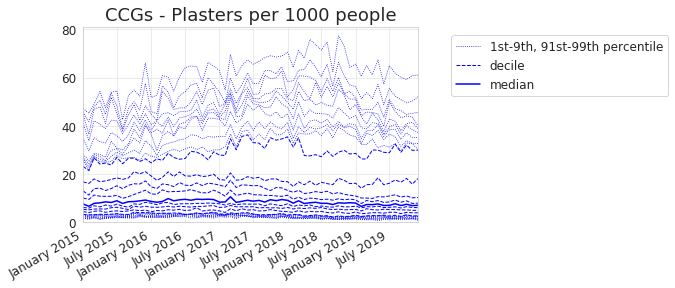

In [7]:
#plot deciles 
charts.deciles_chart(
        lidocaine_and_listsize,
        period_column='month',
        column= 'plasters_per_1000',
        title="CCGs - Plasters per 1000 people",
        show_outer_percentiles=True)
plt.show()

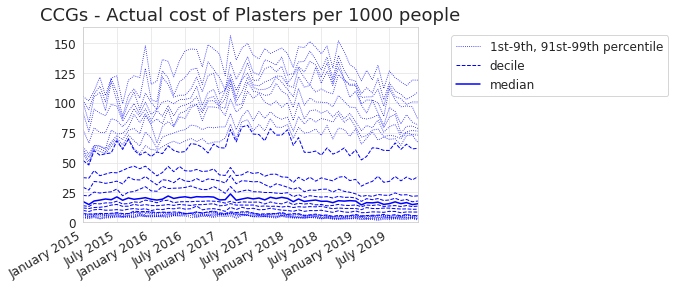

In [8]:
#plot deciles 
charts.deciles_chart(
        lidocaine_and_listsize,
        period_column='month',
        column= 'actual_cost_per_1000',
        title="CCGs - Actual cost of Plasters per 1000 people",
        show_outer_percentiles=True)
plt.show()

## Charts
Here we will draw some charts to ilustrate national patterns

In [ ]:
# total number of patches
ax = df_lidocaine.groupby(["month"])['quantity_of_plasters'].sum().plot(kind='line', title="Total Lidocaine Patches")
ax.axvline(pd.to_datetime('2017-07-01'), color='black', linestyle='--', lw=2) ##policy announced
ax.axvline(pd.to_datetime('2017-11-01'), color='black', linestyle='--', lw=2) ##consultation implemented
plt.ylim(0, 800000)

In [ ]:
# total actual cost
ax = df_lidocaine.groupby(["month"])['actual_cost'].sum().plot(kind='line', title="Total Lidocaine Actual Cost")
ax.axvline(pd.to_datetime('2017-07-01'), color='black', linestyle='--', lw=2) ##policy announced
ax.axvline(pd.to_datetime('2017-11-01'), color='black', linestyle='--', lw=2) ##consultation implemented
plt.ylim(0, )

In [ ]:
# total net cost

In [ ]:
ax = df_lidocaine.groupby(["month"])['net_cost'].sum().plot(kind='line', title="Total Lidocaine Net Cost")
ax.axvline(pd.to_datetime('2017-07-01'), color='black', linestyle='--', lw=2) ##policy announced
ax.axvline(pd.to_datetime('2017-11-01'), color='black', linestyle='--', lw=2) ##consultation implemented
plt.ylim(0, )